In [388]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [389]:
df_train = pd.read_csv("train.csv") 
# df_test = pd.read_csv("test.csv") 

print(df_train.info())

print(df_train.shape)
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB
None
(74051, 10)


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [390]:
df_train = df_train[df_train['Sex'] == 'M']
le = LabelEncoder()
df_train.drop(columns='id', axis=1, inplace=True)
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
2,0,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
5,0,1.5000,1.1750,0.4125,28.845616,13.409313,6.789705,7.937860,10
6,0,1.5750,1.1375,0.3500,30.022120,11.935140,7.342521,8.646598,11
9,0,1.0250,0.7625,0.2625,10.305043,4.493396,2.126212,2.976698,11
12,0,1.3500,1.0250,0.3500,20.964455,8.504850,4.635143,6.945627,10


In [391]:
from sklearn.model_selection import train_test_split

X_train = df_train.drop(columns=['Age'])
y_train = df_train['Age']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)


## Implémentation maison

In [392]:
def loss(x, y, w, b):
    y_hat = np.exp(x @ w + b)
    error = (y_hat - y * np.log(np.maximum(y_hat, 1e-8))).mean()  # Éviter log(0)
    return error


In [393]:
def grad(x, y, w, b):
    M, n = x.shape
    y_hat = np.exp(x @ w + b)
    dw = (x.T @ (y_hat - y)) / M
    db = (y_hat - y).mean()
    return dw, db

def poisson_gradient_descent(x, y, w, b, lr=0.01, epochs=100):
    m = len(y)
    loss_history = []
    
    for _ in range(epochs):
        y_hat = np.exp(x @ w + b)  

        dw = (x.T @ (y_hat - y)) / m
        db = np.sum(y_hat - y) / m

        w -= lr * dw
        b -= lr * db

        loss_history.append(loss(x, y, w, b))
    
    return w, b, loss_history

In [394]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


loss_history = []
poisson_model = PoissonRegressor(alpha=0.01, max_iter=1, warm_start=True)  # `warm_start=True` permet l'apprentissage itératif

num_iterations = 100
for i in range(num_iterations):
    poisson_model.fit(X_train, y_train)
    y_train_pred = poisson_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    loss_history.append(mse)



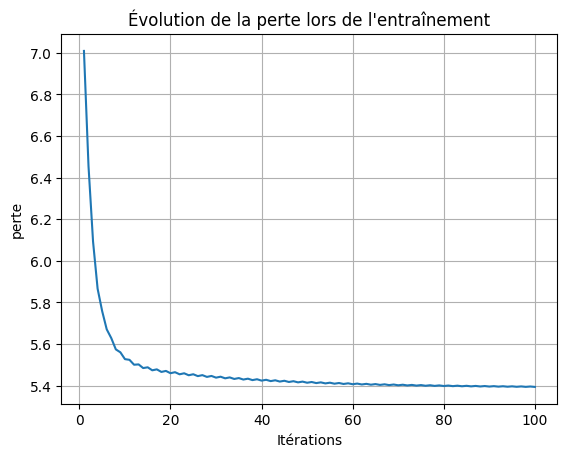

In [395]:
plt.plot(range(1, num_iterations + 1), loss_history, linestyle='-')
plt.xlabel("Itérations")
plt.ylabel("perte")
plt.title("Évolution de la perte lors de l'entraînement")
plt.grid()
plt.show()

In [396]:
y_train_pred = poisson_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)

print(f"Erreur quadratique moyenne (MSE) sur train: {mse:.4f}")

Erreur quadratique moyenne (MSE) sur train: 5.3936


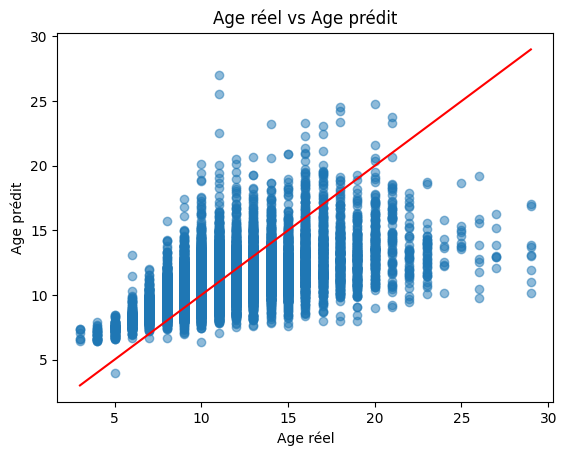

In [397]:
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', label='y=x')

plt.xlabel("Age réel")
plt.ylabel("Age prédit")
plt.title("Age réel vs Age prédit")
plt.show()

In [398]:
# Affichage des coefficients du modèle
feature_names = df_train.drop(columns=['Age']).columns  # Extract feature names from the original dataframe
coefficients = poisson_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)


          Feature  Coefficient
4          Weight     0.149809
7    Shell Weight     0.126957
3          Height     0.053334
2        Diameter     0.035586
1          Length     0.005935
0             Sex     0.000000
6  Viscera Weight    -0.029020
5  Shucked Weight    -0.241945


In [399]:
from sklearn.metrics import r2_score

y_test_pred = poisson_model.predict(X_test)


r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Accuracy): {r2:.4f}")

R-squared (Accuracy): 0.3539


In [400]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Importing CSV file
df = pd.read_csv('Nigerian_Road_Traffic_Crashes_2020_2024.csv')

In [401]:
data_types = df.dtypes
print(data_types)

Quarter                    object
State                      object
Total_Crashes               int64
Num_Injured                 int64
Num_Killed                  int64
Total_Vehicles_Involved     int64
SPV                         int64
DAD                         int64
PWR                         int64
FTQ                         int64
Other_Factors               int64
dtype: object


In [402]:
df.head()


,Quarter,State,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,Other_Factors
0,Q4 2020,Abia,30,146,31,37,19,0,0,0,18
1,Q4 2020,Adamawa,77,234,36,94,57,0,0,0,37
2,Q4 2020,Akwa Ibom,22,28,7,24,15,0,0,1,8
3,Q4 2020,Anambra,72,152,20,83,43,1,0,0,39
4,Q4 2020,Bauchi,154,685,90,140,74,0,0,0,66


In [403]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Quarter                  518 non-null    object
 1   State                    518 non-null    object
 2   Total_Crashes            518 non-null    int64 
 3   Num_Injured              518 non-null    int64 
 4   Num_Killed               518 non-null    int64 
 5   Total_Vehicles_Involved  518 non-null    int64 
 6   SPV                      518 non-null    int64 
 7   DAD                      518 non-null    int64 
 8   PWR                      518 non-null    int64 
 9   FTQ                      518 non-null    int64 
 10  Other_Factors            518 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 44.6+ KB


In [404]:
df.describe()


,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,Other_Factors
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,83.517375,245.631274,40.600386,100.667954,37.903475,0.140927,0.355212,23.824324,38.444015
std,77.023061,201.131483,36.858302,108.567113,57.093042,0.454320,1.677385,51.024267,61.983992
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-348.000000
25%,30.000000,96.250000,15.000000,32.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,58.000000,185.500000,30.000000,64.000000,15.000000,0.000000,0.000000,0.000000,27.000000
75%,107.750000,331.500000,55.750000,134.750000,55.000000,0.000000,0.000000,21.000000,57.000000
max,538.000000,1149.000000,224.000000,864.000000,340.000000,4.000000,25.000000,425.000000,586.000000


In [405]:
print(df.shape)


(518, 11)


In [406]:
# Drop rows with any missing values
df_cleaned = df.dropna()

# Drop columns with any missing values
df_cleaned = df.dropna(axis=1)

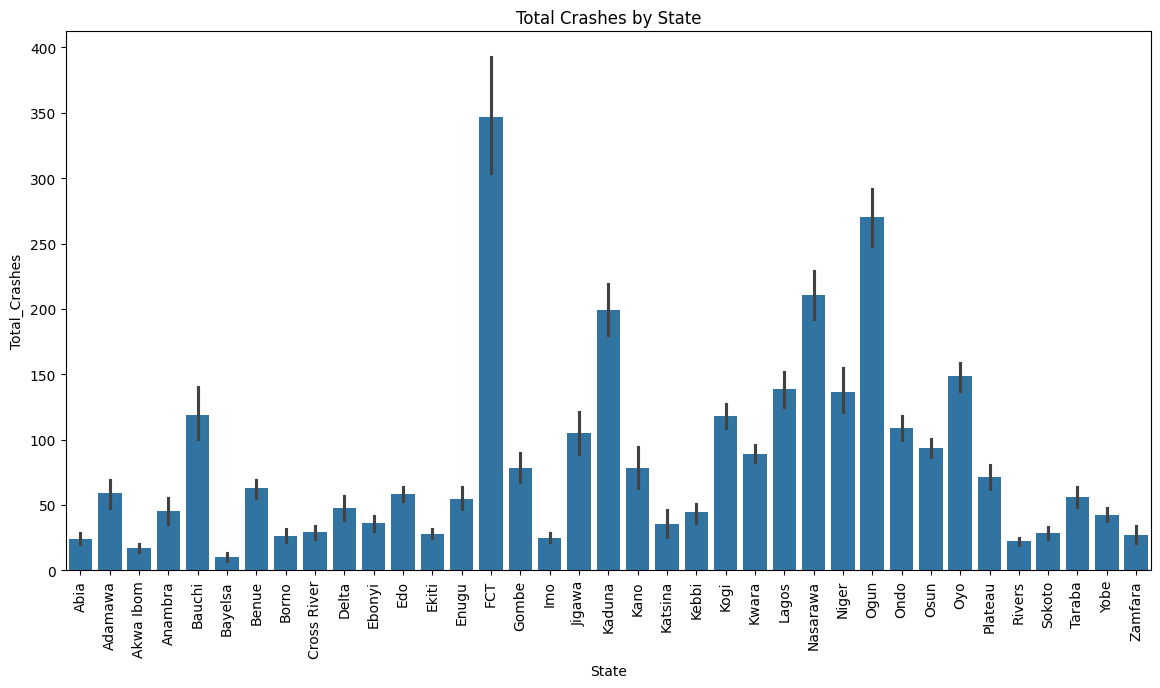

In [407]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of Total Crashes by State
plt.figure(figsize=(14, 7))
sns.barplot(x='State', y='Total_Crashes', data=df)
plt.title('Total Crashes by State')
plt.xticks(rotation=90)
plt.show()

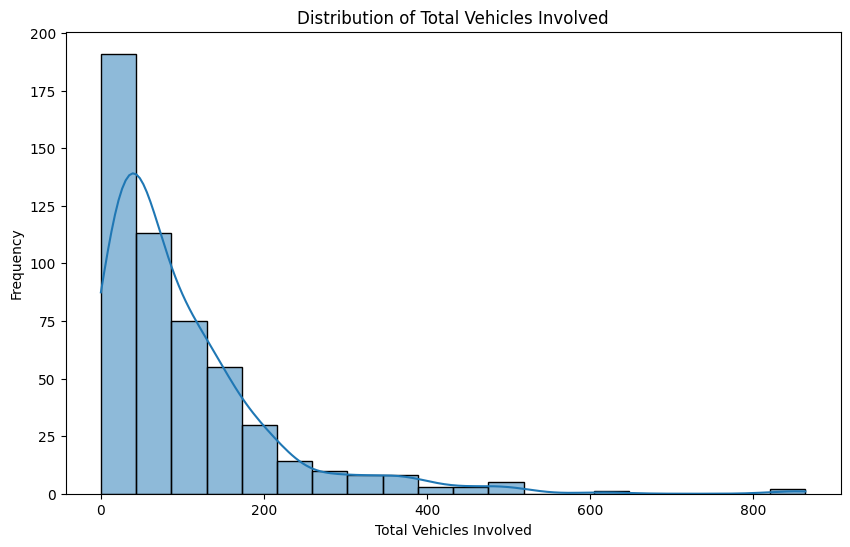

In [408]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Vehicles_Involved'], bins=20, kde=True)
plt.title('Distribution of Total Vehicles Involved')
plt.xlabel('Total Vehicles Involved')
plt.ylabel('Frequency')
plt.show()

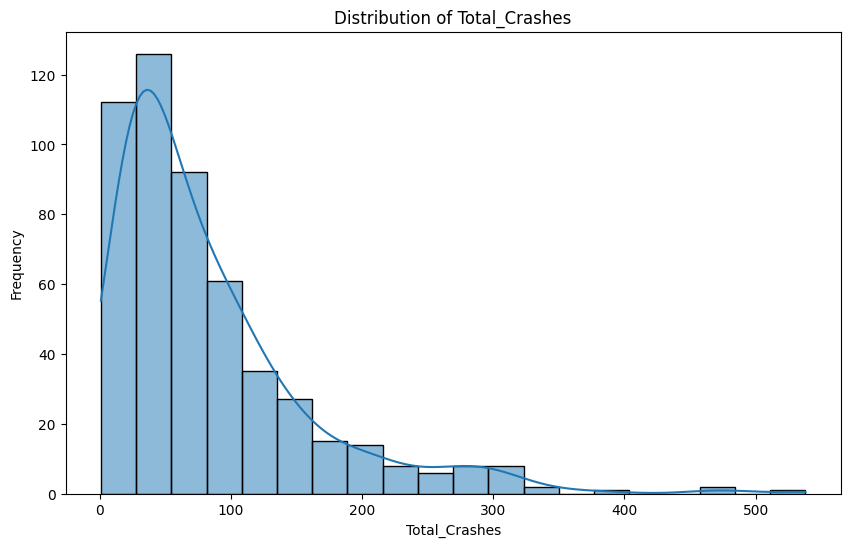

In [409]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Crashes'], bins=20, kde=True)
plt.title('Distribution of Total_Crashes')
plt.xlabel('Total_Crashes')
plt.ylabel('Frequency')
plt.show()

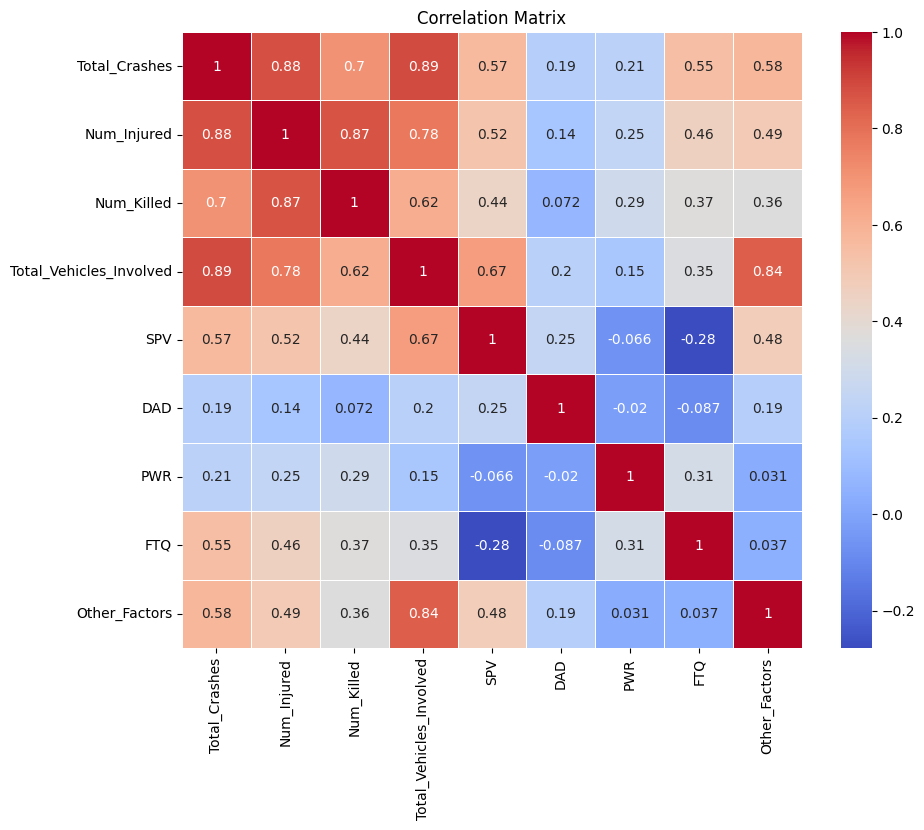

In [410]:
numeric_df = df.select_dtypes(include=[float, int])

plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

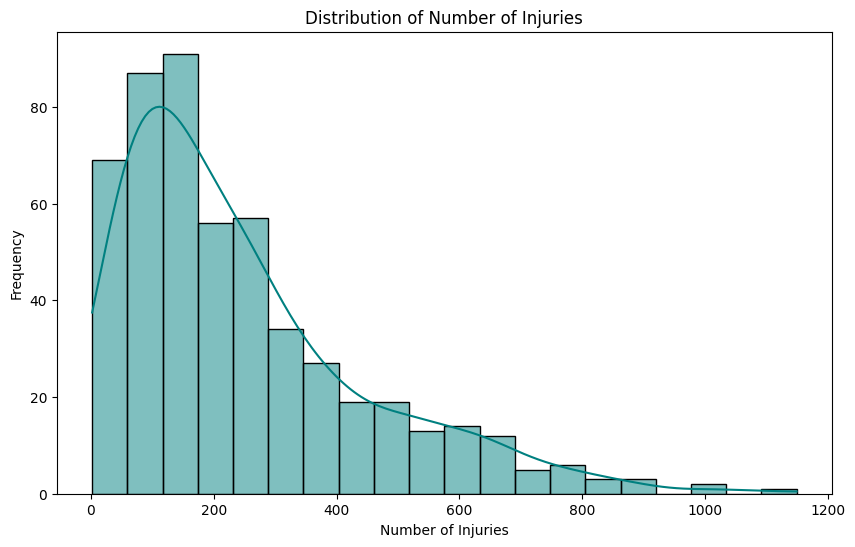

In [411]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Num_Injured'], bins=20, kde=True, color='teal')
plt.title('Distribution of Number of Injuries')
plt.xlabel('Number of Injuries')
plt.ylabel('Frequency')
plt.show()

Final Mean Squared Error: 1412.647189948585
R^2 Score: 0.7364818926498102


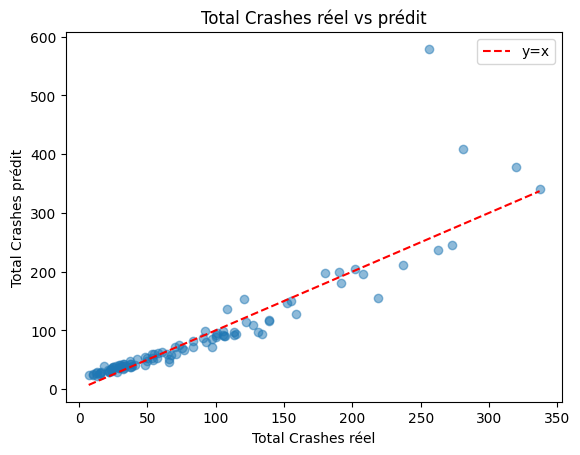

                    Feature  Coefficient
46              State_Lagos     0.572785
0               Num_Injured     0.375320
47           State_Nasarawa     0.341971
52                State_Oyo     0.322108
50               State_Ondo     0.257355
36                State_FCT     0.241791
44               State_Kogi     0.204187
51               State_Osun     0.167841
37              State_Gombe     0.152390
53            State_Plateau     0.150007
3                       SPV     0.135124
16          Quarter_Q3 2022     0.102225
15          Quarter_Q3 2021     0.101708
45              State_Kwara     0.099487
56             State_Taraba     0.095505
2   Total_Vehicles_Involved     0.085896
33                State_Edo     0.083803
6                       FTQ     0.078272
9           Quarter_Q1 2022     0.078130
49               State_Ogun     0.077576
28              State_Benue     0.077251
20          Quarter_Q4 2022     0.071474
19          Quarter_Q4 2021     0.069450
23            St

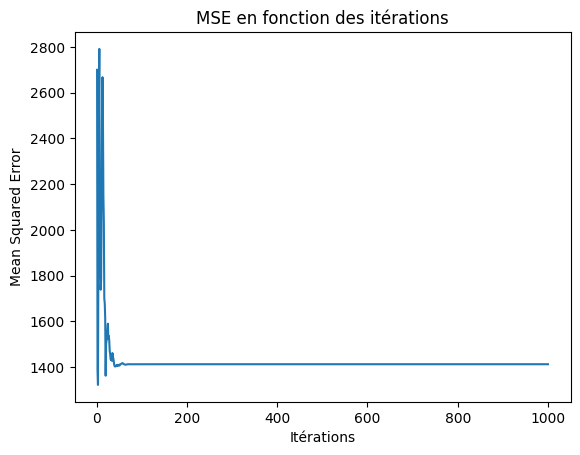

In [412]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['Total_Crashes'])  # Supposons que 'Total_Crashes' est la variable cible
y = df_cleaned['Total_Crashes']

# Encodage des variables catégorielles et mise à l'échelle des variables numériques
categorical_features = ['Quarter', 'State']
numeric_features = X.drop(columns=categorical_features).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Prétraitement des données
X_processed = preprocessor.fit_transform(X)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialisation du modèle
poisson_model = PoissonRegressor(max_iter=1000, tol=1e-4)

# Liste pour stocker les valeurs de MSE à chaque itération
mse_values = []

# Boucle d'entraînement personnalisée
for i in range(1, poisson_model.max_iter + 1):
    poisson_model.max_iter = i
    poisson_model.fit(X_train, y_train)
    y_pred = poisson_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Évaluation finale du modèle
poisson_model.fit(X_train, y_train)
y_pred = poisson_model.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Final Mean Squared Error: {mse_final}")
print(f"R^2 Score: {r2}")

# Visualisation des résultats
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='y=x')
plt.legend()
plt.xlabel("Total Crashes réel")
plt.ylabel("Total Crashes prédit")
plt.title("Total Crashes réel vs prédit")
plt.show()

# Affichage des coefficients
coefficients = poisson_model.coef_
feature_names = numeric_features.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)

# Tracé de la MSE en fonction des itérations
plt.plot(range(1, poisson_model.max_iter + 1), mse_values)
plt.xlabel("Itérations")
plt.ylabel("Mean Squared Error")
plt.title("MSE en fonction des itérations")
plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='y=x')
